In [1]:
# Mount drive
import os
from google.colab import drive
%cd /content
drive.mount('/content/drive', force_remount=True)
%cd 'drive/My Drive/Colab Notebooks/NLP/project/code'
%ls -l
print(os.listdir())

/content
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/NLP/project/code
total 3368
-rw------- 1 root root 109039 May 10 14:28 Benchmark_embeddings_advanced.ipynb
-rw------- 1 root root 129633 May 14 12:31 Benchmark_embeddings.ipynb
-rw------- 1 root root   3534 Apr 22 16:32 cleaning.py
-rw------- 1 root root  60561 May  9 16:14 combine_features.ipynb
-rw------- 1 root root   4341 May 13 18:02 compute_embeddings.py
-rw------- 1 root root  68923 May 14 09:05 LSTM_model.ipynb
-rw------- 1 root root 363996 May  9 10:48 master.zip
-rw------- 1 root root 363996 May  9 10:49 master.zip.1
-rw------- 1 root root 363996 May  9 10:51 master.zip.2
-rw------- 1 root root   4350 May 14 10:55 modeling.py
drwx------ 2 root root   4096 May 14 11:19 __pycache__/
-rw------- 1 root root  21800 Apr 25 09:06 pytorch_tuto.ipynb
drwx------ 2 root root   4096 May  1 16:25 sent2vec-master/
-rw------- 1 root root 926824 May 10 10:38 test.h5
-rw------- 1 root root   4912 May 13 18:58 transform

In [2]:
!pip install gensim==3.8.0

     |████████████████████████████████| 24.2MB 130kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
import pandas as pd
import numpy as np
import random
import re
import time
from string import punctuation
import scipy.io
import matplotlib.pyplot as plt

import nltk
import scipy.sparse as sp
import gensim
# import nltk
# from nltk.corpus import stopwords
# nltk.download('stopwords')
# from nltk.stem import SnowballStemmer
# nltk.download('punkt')
# from nltk.stem import WordNetLemmatizer 
# nltk.download('wordnet')

# from gensim.test.utils import datapath, get_tmpfile
# from gensim.models import KeyedVectors
# from gensim.scripts.glove2word2vec import glove2word2vec

import torch
import torch.nn as nn
from torchtext.data import Field, LabelField, TabularDataset, Iterator, BucketIterator
from torchtext import vocab
import torch.optim as optim

import transform_dataset
import compute_embeddings
import modeling

import pickle

def save_pickle(filename, reviews_tokenized):
  with open(filename, 'wb') as f:
    pickle.dump(reviews_tokenized, f)

def load_pickle(filename):
  with open(filename, 'rb') as f:
    x = pickle.load(f)
  return x

print(gensim.__version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
3.8.0


In [0]:
# import numpy as np

# import xgboost as xgb

# import tensorflow
# import tensorflow.keras as keras
# from tensorflow.keras import layers

# from sklearn.base import clone
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import log_loss, accuracy_score, f1_score, precision_score, recall_score
# from sklearn.pipeline import Pipeline
# from sklearn.multiclass import OneVsRestClassifier

# def get_simple_nn_model(input_dim, hidden_sizes=[32, 16, 8]):
#   model = keras.Sequential()
#   for i, hidden in enumerate(hidden_sizes):
#     if i==0:
#       model.add(layers.Dense(hidden, activation='relu', input_shape=(input_dim, )))
#     else:
#       model.add(layers.Dense(hidden, activation='relu'))
#   model.add(layers.Dense(1, activation='sigmoid'))

#   model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_crossentropy', 'accuracy'])

#   return model

# def model_efficiency(embs, labels, model=LogisticRegression(), validation=False, reinitialize=True, **params):
#   X_train, X_valid, y_train, y_valid = train_test_split(embs, labels, train_size = 0.7, random_state=42, shuffle=True, stratify=labels)
  
#   y_train, y_valid = np.array(y_train), np.array(y_valid)
  
#   if issubclass(type(model), (tensorflow.python.keras.engine.sequential.Sequential, tensorflow.keras.Model)):
#       params['validation_data'] = (X_valid, y_valid)

#   if reinitialize:
#     if issubclass(type(model), (tensorflow.python.keras.engine.sequential.Sequential, tensorflow.keras.Model)):
#       model_copy = keras.models.clone_model(model)
#       model_copy.build((None, model.input.shape))
#       model_copy.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_crossentropy', 'accuracy'])
#       model = model_copy
#     else:
#         try:
#             model = clone(model)
#         except Exception:
#             print('model not reinitialized')
#             pass
      
#   model.fit(X_train, y_train, **params)
  
#   if hasattr(model, 'predict_proba'):
#       proba_predictions_train = model.predict_proba(X_train)
#       proba_predictions_valid = model.predict_proba(X_valid)
#   else:
#       proba_predictions_train = model.predict(X_train)
#       proba_predictions_valid = model.predict(X_valid)
          
#   if proba_predictions_train.shape[1]==2:
#       predictions_train = proba_predictions_train.argmax(axis=1)
#       predictions_valid = proba_predictions_valid.argmax(axis=1)
#   else:
#       predictions_train = proba_predictions_train >= 0.5
#       predictions_valid = proba_predictions_valid >= 0.5

#   loss_train = log_loss(y_train, proba_predictions_train)
#   loss_valid = log_loss(y_valid, proba_predictions_valid)

#   accuracy_train = accuracy_score(y_train, predictions_train)
#   accuracy_valid = accuracy_score(y_valid, predictions_valid)

#   f1_train = f1_score(y_train, predictions_train)
#   f1_valid = f1_score(y_valid, predictions_valid)

#   return {'loss':np.round(loss_train,2), 'accuracy':np.round(accuracy_train,2), 'f1':np.round(f1_train,2)}, \
#          {'loss':np.round(loss_valid,2), 'accuracy':np.round(accuracy_valid,2), 'f1':np.round(f1_valid,2)}
         
         
# def model_efficiency_xgb(embs, labels, params={'objective':'binary:logistic', 'eval_metric':'logloss', 'eta':0.02, 'max_depth':4}):

#   X_train, X_valid, y_train, y_valid = train_test_split(embs, labels, train_size = 0.7, random_state=42, shuffle=True, stratify=labels)

#   d_train = xgb.DMatrix(X_train, label=y_train)
#   d_valid = xgb.DMatrix(X_valid, label=y_valid)
#   watchlist = [(d_train, 'train'), (d_valid, 'valid')]

#   model = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

#   proba_predictions_train = model.predict(d_train)
#   proba_predictions_valid = model.predict(d_valid)

#   predictions_train = proba_predictions_train >= 0.5
#   predictions_valid = proba_predictions_valid >= 0.5

#   loss_train = log_loss(y_train, proba_predictions_train)
#   loss_valid = log_loss(y_valid, proba_predictions_valid)

#   accuracy_train = accuracy_score(y_train, predictions_train)
#   accuracy_valid = accuracy_score(y_valid, predictions_valid)

#   f1_train = f1_score(y_train, predictions_train)
#   f1_valid = f1_score(y_valid, predictions_valid)

#   return {'loss':np.round(loss_train,2), 'accuracy':np.round(accuracy_train,2), 'f1':np.round(f1_train,2)}, \
#          {'loss':np.round(loss_valid,2), 'accuracy':np.round(accuracy_valid,2), 'f1':np.round(f1_valid,2)}

In [0]:
questions1, questions2, is_duplicates = transform_dataset.clean_quora()

# use this for tokenizer approach
cleaned_questions1, cleaned_questions2, cleaned_is_duplicates = transform_dataset.clean_quora(output='tokenized_list')

In [0]:
# pytorch loader
# iterator = transform_dataset.clean_quora(output = 'iterator_from_file')

# Transformation: a small comparison

We check to what extend the tokenizations are efficient

In [0]:
def tokenizer1(x):
  return transform_dataset.apply_all(x, transform_dataset.preprocessing_factory(filter(lambda x: x!='nothing', ['xml', 'punct', 'advToken'])))

def tokenizer2(x):
  return transform_dataset.apply_all(x, transform_dataset.preprocessing_factory(filter(lambda x: x!='nothing', ['xml', 'punct', 'simpleToken', 'stopwords', 'lemming'])))

In [0]:
cleaned_questions1_1, cleaned_questions2_1, _ = transform_dataset.clean_quora(output='tokenized_list', tokenizer = tokenizer1)
cleaned_questions1_2, cleaned_questions2_2, _ = transform_dataset.clean_quora(output='tokenized_list', tokenizer = tokenizer2)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [0]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[=================================================-] 99.6% 1656.6/1662.8MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
perc = {}
diff = {}

cleaned_questions1, cleaned_questions2
perc['tokenizer'] = transform_dataset.common_percentage(cleaned_questions1 + cleaned_questions2, wv.vocab)
diff['tokenizer'] = transform_dataset.check_difference(cleaned_questions1 + cleaned_questions2, wv.vocab)

perc['tokenizer1'] = transform_dataset.common_percentage(cleaned_questions1_1 + cleaned_questions2_1, wv.vocab)
diff['tokenizer1'] = transform_dataset.check_difference(cleaned_questions1_1 + cleaned_questions2_1, wv.vocab)

perc['tokenizer2'] = transform_dataset.common_percentage(cleaned_questions1_2 + cleaned_questions2_2, wv.vocab)
diff['tokenizer2'] = transform_dataset.check_difference(cleaned_questions1_2 + cleaned_questions2_2, wv.vocab)

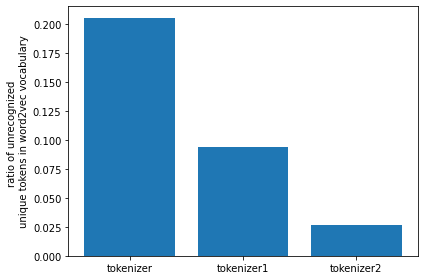

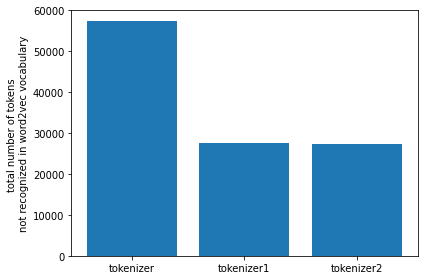

In [0]:
plt.bar(*zip(*list({k:1-v for k,v in perc.items()}.items())))
plt.ylabel('ratio of unrecognized \nunique tokens in word2vec vocabulary')
plt.tight_layout()
plt.savefig('../images/{}.png'.format('ratio_unrecognized'))
plt.show()

plt.bar(*zip(*list({k:len(v) for k,v in diff.items()}.items())))
plt.ylabel('total number of tokens \nnot recognized in word2vec vocabulary')
plt.tight_layout()
plt.savefig('../images/{}.png'.format('total_number_unrecognized'))
plt.show()

We see that depending on the preprocessing, there can be a big difference in the number of words that are recognized in the pretrained embeddings

# Benchmark

In [0]:
# use this for tokenizer2 preprocessing
def tokenizer2(x):
  return transform_dataset.apply_all(x, transform_dataset.preprocessing_factory(filter(lambda x: x!='nothing', ['xml', 'punct', 'simpleToken', 'stopwords', 'lemming'])))
  
cleaned_questions1, cleaned_questions2, cleaned_is_duplicates = transform_dataset.clean_quora(output='tokenized_list', tokenizer = tokenizer2)

In [0]:
# loading/saving if necessary

# save_pickle('../data/tokenizer2_questions1', cleaned_questions1)
# save_pickle('../data/tokenizer2_questions2', cleaned_questions2)

# cleaned_questions1 = load_pickle('../data/tokenizer2_questions1')
# cleaned_questions2 = load_pickle('../data/tokenizer2_questions2')

In [0]:
# load results, if necessary

processing_time = {}
metrics_train = {}
metrics_train_nn = {}

metrics_valid = {}
metrics_valid_nn = {}

# -----------------------------------------------------------------------
# Tokenizer processing

# processing_time = {'doc2vec': 682.49, 'sent2vec': 9.01, 'SIF': 18.9, 'SBERT': 3550.54, 'Count': 6.78, 'TFIDF': 6.84}

# metrics_train['doc2vec'] = {'loss': 0.54, 'accuracy': 0.71, 'f1': 0.57}
# metrics_valid['doc2vec'] = {'loss': 0.54, 'accuracy': 0.71, 'f1': 0.57}
# metrics_train_nn['doc2vec'] = {'loss': 0.47, 'accuracy': 0.76, 'f1': 0.68}
# metrics_valid_nn['doc2vec'] = {'loss': 0.49, 'accuracy': 0.74, 'f1': 0.66}

# metrics_train['sent2vec'] = {'loss': 0.54, 'accuracy': 0.73, 'f1': 0.58}
# metrics_valid['sent2vec'] = {'loss': 0.54, 'accuracy': 0.73, 'f1': 0.58}
# metrics_train_nn['sent2vec'] = {'loss': 0.39, 'accuracy': 0.81, 'f1': 0.74}
# metrics_valid_nn['sent2vec'] = {'loss': 0.45, 'accuracy': 0.78, 'f1': 0.69}

# metrics_train['SBERT'] = {'loss': 0.41, 'accuracy': 0.81, 'f1': 0.73}
# metrics_valid['SBERT'] = {'loss': 0.42, 'accuracy': 0.8, 'f1': 0.73}
# metrics_train_nn['SBERT'] = {'loss': 0.34, 'accuracy': 0.84, 'f1': 0.79}
# metrics_valid_nn['SBERT'] = {'loss': 0.37, 'accuracy': 0.83, 'f1': 0.77}

# metrics_train['SIF'] = {'loss': 0.6, 'accuracy': 0.69, 'f1': 0.47}
# metrics_valid['SIF'] = {'loss': 0.59, 'accuracy': 0.69, 'f1': 0.47}
# metrics_train_nn['SIF'] = {'loss': 0.54, 'accuracy': 0.66, 'f1': 0.57}
# metrics_valid_nn['SIF'] = {'loss': 0.54, 'accuracy': 0.66, 'f1': 0.57}

# metrics_train['Count'] = {'loss': 0.63, 'accuracy': 0.63, 'f1': 0.01}
# metrics_valid['Count'] = {'loss': 0.63, 'accuracy': 0.63, 'f1': 0.01}
# metrics_train_nn['Count'] = {'loss': 0.54, 'accuracy': 0.71, 'f1': 0.51}
# metrics_valid_nn['Count'] = {'loss': 0.54, 'accuracy': 0.71, 'f1': 0.51}

# metrics_train['TFIDF'] = {'loss': 0.63, 'accuracy': 0.63, 'f1': 0.01}
# metrics_valid['TFIDF'] = {'loss': 0.63, 'accuracy': 0.63, 'f1': 0.01}
# metrics_train_nn['TFIDF'] = {'loss': 0.55, 'accuracy': 0.71, 'f1': 0.5}
# metrics_valid_nn['TFIDF'] = {'loss': 0.55, 'accuracy': 0.71, 'f1': 0.5}

# metrics_train['Count+TFIDF'] = {'loss': 0.56, 'accuracy': 0.65, 'f1': 0.48}
# metrics_valid['Count+TFIDF'] = {'loss': 0.56, 'accuracy': 0.65, 'f1': 0.49}
# metrics_train_nn['Count+TFIDF'] = {'loss': 0.52, 'accuracy': 0.67, 'f1': 0.61}
# metrics_valid_nn['Count+TFIDF'] = {'loss': 0.52, 'accuracy': 0.67, 'f1': 0.61}

# -----------------------------------------------------------------------
# Tokenizer2 processing

processing_time = {'doc2vec': 618.72, 'sent2vec': 7.81, 'SIF': 3.68, 'SBERT': 3550.54, 'Count': 6.44, 'TFIDF': 6.21}

metrics_train['doc2vec'] = {'loss': 0.54, 'accuracy': 0.71, 'f1': 0.57}
metrics_valid['doc2vec'] = {'loss': 0.54, 'accuracy': 0.71, 'f1': 0.57}
metrics_train_nn['doc2vec'] = {'loss': 0.34, 'accuracy': 0.84, 'f1': 0.8}
metrics_valid_nn['doc2vec'] = {'loss': 0.37, 'accuracy': 0.83, 'f1': 0.78}

metrics_train['sent2vec'] = {'loss': 0.56, 'accuracy': 0.72, 'f1': 0.56}
metrics_valid['sent2vec'] = {'loss': 0.56, 'accuracy': 0.72, 'f1': 0.56}
metrics_train_nn['sent2vec'] = {'loss': 0.35, 'accuracy': 0.84, 'f1': 0.77}
metrics_valid_nn['sent2vec'] = {'loss': 0.38, 'accuracy': 0.83, 'f1': 0.76}

metrics_train['SBERT'] = {'loss': 0.41, 'accuracy': 0.81, 'f1': 0.73}
metrics_valid['SBERT'] = {'loss': 0.42, 'accuracy': 0.8, 'f1': 0.73}
metrics_train_nn['SBERT'] = {'loss': 0.34, 'accuracy': 0.84, 'f1': 0.79}
metrics_valid_nn['SBERT'] = {'loss': 0.37, 'accuracy': 0.83, 'f1': 0.77}

metrics_train['SIF'] = {'loss': 0.6, 'accuracy': 0.69, 'f1': 0.47}
metrics_valid['SIF'] = {'loss': 0.59, 'accuracy': 0.69, 'f1': 0.47}
metrics_train_nn['SIF'] = {'loss': 0.49, 'accuracy': 0.75, 'f1': 0.65}
metrics_valid_nn['SIF'] = {'loss': 0.51, 'accuracy': 0.74, 'f1': 0.64}

metrics_train['Count'] = {'loss': 0.63, 'accuracy': 0.63, 'f1': 0.0}
metrics_valid['Count'] = {'loss': 0.63, 'accuracy': 0.63, 'f1': 0.0}
metrics_train_nn['Count'] = {'loss': 0.56, 'accuracy': 0.7, 'f1': 0.45}
metrics_valid_nn['Count'] = {'loss': 0.56, 'accuracy': 0.7, 'f1': 0.45}

metrics_train['TFIDF'] = {'loss': 0.63, 'accuracy': 0.63, 'f1': 0.0}
metrics_valid['TFIDF'] = {'loss': 0.63, 'accuracy': 0.63, 'f1': 0.0}
metrics_train_nn['TFIDF'] = {'loss': 0.55, 'accuracy': 0.71, 'f1': 0.51}
metrics_valid_nn['TFIDF'] = {'loss': 0.55, 'accuracy': 0.71, 'f1': 0.51}

metrics_train['Count+TFIDF'] = {'loss': 0.57, 'accuracy': 0.66, 'f1': 0.5}
metrics_valid['Count+TFIDF'] = {'loss': 0.57, 'accuracy': 0.66, 'f1': 0.5}
metrics_train_nn['Count+TFIDF'] = {'loss': 0.54, 'accuracy': 0.67, 'f1': 0.55}
metrics_valid_nn['Count+TFIDF'] = {'loss': 0.54, 'accuracy': 0.67, 'f1': 0.55}

# Doc2Vec

### library reference
- https://radimrehurek.com/gensim/models/doc2vec.html

### pre-trained embeddings
- https://wikipedia2vec.github.io/wikipedia2vec/pretrained/

Download enwiki_20180420 (window=5, iteration=10, negative=15), 300d and put it in the embeddings repository


In [0]:
# adapt the path if needed
# model = compute_embeddings.Doc2Vec_model('../../../stage/embeddings/doc2vec/enwiki_dbow/doc2vec.bin')
model = compute_embeddings.Doc2Vec_model('../embeddings/doc2vec/enwiki_dbow/doc2vec.bin')
model.load_model()

In [0]:
%%time
start_time = time.time()
embs1 = model.calculate_embeddings(cleaned_questions1)
embs2 = model.calculate_embeddings(cleaned_questions2)

end_time = time.time()
processing_time['doc2vec'] = np.round(end_time-start_time,2)

In [0]:
# np.save('../data/doc2vec_embeddings1.npy', embs1)
# np.save('../data/doc2vec_embeddings2.npy', embs2)

# embs1 = np.load('../data/doc2vec_embeddings1.npy')
# embs2 = np.load('../data/doc2vec_embeddings2.npy')

In [79]:
features = np.concatenate((embs1, embs2, np.abs(embs2-embs1)), axis=1)
metric_train, metric_valid = modeling.model_efficiency(features, is_duplicates)
metrics_train['doc2vec'] = metric_train
metrics_valid['doc2vec'] = metric_valid
print(metric_train)
print(metric_valid)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'loss': 0.54, 'accuracy': 0.71, 'f1': 0.57}
{'loss': 0.54, 'accuracy': 0.71, 'f1': 0.57}


In [80]:
# features = np.concatenate((embs1, embs2, np.abs(embs2-embs1)), axis=1)
model = modeling.get_simple_nn_model(features.shape[1], hidden_sizes=[32, 16, 8])
metric_train, metric_valid = modeling.model_efficiency(features, is_duplicates, model=model, epochs=5, batch_size=64)
# metric_train, metric_valid = model_efficiency(features, is_duplicates, model=model, epochs=5, batch_size=64)
metrics_train_nn['doc2vec'] = metric_train
metrics_valid_nn['doc2vec'] = metric_valid
print(metric_train)
print(metric_valid)

Epoch 1/5
4422/4422 [==============================] - 22s 5ms/step - loss: 0.5313 - binary_crossentropy: 0.5313 - accuracy: 0.7097 - val_loss: 0.5118 - val_binary_crossentropy: 0.5118 - val_accuracy: 0.7269
Epoch 2/5
4422/4422 [==============================] - 21s 5ms/step - loss: 0.5060 - binary_crossentropy: 0.5060 - accuracy: 0.7305 - val_loss: 0.5016 - val_binary_crossentropy: 0.5016 - val_accuracy: 0.7331
Epoch 3/5
4422/4422 [==============================] - 21s 5ms/step - loss: 0.4949 - binary_crossentropy: 0.4949 - accuracy: 0.7391 - val_loss: 0.4987 - val_binary_crossentropy: 0.4987 - val_accuracy: 0.7358
Epoch 4/5
4422/4422 [==============================] - 21s 5ms/step - loss: 0.4869 - binary_crossentropy: 0.4869 - accuracy: 0.7457 - val_loss: 0.4925 - val_binary_crossentropy: 0.4925 - val_accuracy: 0.7419
Epoch 5/5
4422/4422 [==============================] - 21s 5ms/step - loss: 0.4804 - binary_crossentropy: 0.4804 - accuracy: 0.7496 - val_loss: 0.4893 - val_binary_cros

{'doc2vec': 682.49}


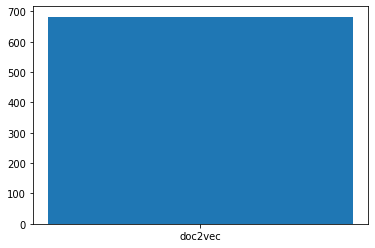

In [0]:
plt.bar(*zip(*processing_time.items()))
print(processing_time)

# Sent2Vec

### code
- https://github.com/epfml/sent2vec
- https://github.com/facebookresearch/fastText#models

### pretrained embeddings
- https://github.com/epfml/sent2vec
- https://fasttext.cc/docs/en/english-vectors.html

Download sent2vec_toronto_books_unigrams from https://github.com/epfml/sent2vec and put it in the embeddings repository

Direct link: https://drive.google.com/file/d/0B6VhzidiLvjSOWdGM0tOX1lUNEk/view

In [71]:
# before continuing, download and put the pretrained embeddings in the path called below: https://drive.google.com/file/d/0B6VhzidiLvjSOWdGM0tOX1lUNEk/view
# the code also fires compute_embeddings.download_and_install_git('https://github.com/epfml/sent2vec/archive/master.zip') to download and install the library
# !!! the notebook bugs really hard if the embedding is not present

# model = compute_embeddings.Sent2Vec('../../../stage/embeddings/sent2vec/sent2vec_toronto_books_unigrams')
model = compute_embeddings.Sent2Vec('../embeddings/sent2vec/sent2vec_toronto_books_unigrams')
model.load_model()

package installed


In [74]:
%%time
start_time = time.time()
# embs1 = model.calculate_embeddings(questions1)
# embs2 = model.calculate_embeddings(questions2)

embs1 = model.calculate_embeddings(list(map(lambda x: ' '.join(x), cleaned_questions1)))
embs2 = model.calculate_embeddings(list(map(lambda x: ' '.join(x), cleaned_questions2)))

end_time = time.time()
processing_time['sent2vec'] = np.round(end_time-start_time,2)

CPU times: user 9.75 s, sys: 54.4 ms, total: 9.8 s
Wall time: 9.78 s


In [0]:
# np.save('../data/sent2vec_embeddings1.npy', embs1)
# np.save('../data/sent2vec_embeddings2.npy', embs2)

# embs1 = np.load('../data/sent2vec_embeddings1.npy')
# embs2 = np.load('../data/sent2vec_embeddings2.npy')

In [75]:
features = np.concatenate((embs1, embs2, np.abs(embs2-embs1)), axis=1)
metric_train, metric_valid = modeling.model_efficiency(features, is_duplicates)
metrics_train['sent2vec'] = metric_train
metrics_valid['sent2vec'] = metric_valid
print(metric_train)
print(metric_valid)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'loss': 0.54, 'accuracy': 0.73, 'f1': 0.58}
{'loss': 0.54, 'accuracy': 0.73, 'f1': 0.58}


In [76]:
# features = np.concatenate((embs1, embs2, np.abs(embs2-embs1)), axis=1)
model = modeling.get_simple_nn_model(features.shape[1], hidden_sizes=[32, 16, 8])
metric_train, metric_valid = modeling.model_efficiency(features, is_duplicates, model=model, epochs=5, batch_size=64)
# metric_train, metric_valid = model_efficiency(features, is_duplicates, model=model, epochs=5, batch_size=64)
metrics_train_nn['sent2vec'] = metric_train
metrics_valid_nn['sent2vec'] = metric_valid
print(metric_train)
print(metric_valid)

Epoch 1/5
4422/4422 [==============================] - 21s 5ms/step - loss: 0.5004 - binary_crossentropy: 0.5004 - accuracy: 0.7400 - val_loss: 0.4724 - val_binary_crossentropy: 0.4724 - val_accuracy: 0.7549
Epoch 2/5
4422/4422 [==============================] - 21s 5ms/step - loss: 0.4606 - binary_crossentropy: 0.4606 - accuracy: 0.7664 - val_loss: 0.4601 - val_binary_crossentropy: 0.4601 - val_accuracy: 0.7671
Epoch 3/5
4422/4422 [==============================] - 23s 5ms/step - loss: 0.4397 - binary_crossentropy: 0.4397 - accuracy: 0.7801 - val_loss: 0.4535 - val_binary_crossentropy: 0.4535 - val_accuracy: 0.7717
Epoch 4/5
4422/4422 [==============================] - 21s 5ms/step - loss: 0.4238 - binary_crossentropy: 0.4238 - accuracy: 0.7911 - val_loss: 0.4536 - val_binary_crossentropy: 0.4536 - val_accuracy: 0.7757
Epoch 5/5
4422/4422 [==============================] - 21s 5ms/step - loss: 0.4116 - binary_crossentropy: 0.4116 - accuracy: 0.7982 - val_loss: 0.4475 - val_binary_cros

{'sent2vec': 9.01}


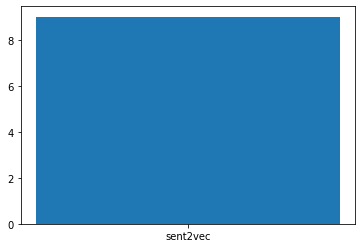

In [0]:
plt.bar(*zip(*processing_time.items()))
print(processing_time)

# SBERT (Sentence BERT)

### code and embeddings
- https://github.com/UKPLab/sentence-transformers

we use by default: bert-base-nli-mean-tokens


In [0]:
# installs the library
# change the path argument of SBERT to use other pretrained networks; default = bert-base-nli-mean-tokens
model = compute_embeddings.SBERT()
model.load_model()

100%|██████████| 405M/405M [00:07<00:00, 55.9MB/s]


In [0]:
%%time
start_time = time.time()
embs1 = np.array(model.calculate_embeddings(questions1))
embs2 = np.array(model.calculate_embeddings(questions2))

end_time = time.time()
processing_time['SBERT'] = np.round(end_time-start_time,2)

CPU times: user 46min 42s, sys: 12min 29s, total: 59min 11s
Wall time: 59min 10s


In [0]:
# np.save('../data/SBERT_embeddings1.npy', embs1)
# np.save('../data/SBERT_embeddings2.npy', embs2)

# embs1 = np.load('../data/SBERT_embeddings1.npy')
# embs2 = np.load('../data/SBERT_embeddings2.npy')

In [8]:
features = np.concatenate((embs1, embs2, np.abs(embs2-embs1)), axis=1)
metric_train, metric_valid = modeling.model_efficiency(features, is_duplicates)
metrics_train['SBERT'] = metric_train
metrics_valid['SBERT'] = metric_valid
print(metric_train)
print(metric_valid)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'loss': 0.41, 'accuracy': 0.81, 'f1': 0.73}
{'loss': 0.42, 'accuracy': 0.8, 'f1': 0.73}


In [19]:
# features = np.concatenate((embs1, embs2, np.abs(embs2-embs1)), axis=1)
model = modeling.get_simple_nn_model(features.shape[1], hidden_sizes=[32, 16, 8])
metric_train, metric_valid = modeling.model_efficiency(features, is_duplicates, model=model, epochs=5, batch_size=64)
# metric_train, metric_valid = model_efficiency(features, is_duplicates, model=model, epochs=5, batch_size=64)
metrics_train_nn['SBERT'] = metric_train
metrics_valid_nn['SBERT'] = metric_valid
print(metric_train)
print(metric_valid)

Epoch 1/5
4422/4422 [==============================] - 20s 5ms/step - loss: 0.4248 - binary_crossentropy: 0.4248 - accuracy: 0.7949 - val_loss: 0.3966 - val_binary_crossentropy: 0.3966 - val_accuracy: 0.8114
Epoch 2/5
4422/4422 [==============================] - 20s 5ms/step - loss: 0.3908 - binary_crossentropy: 0.3908 - accuracy: 0.8152 - val_loss: 0.3922 - val_binary_crossentropy: 0.3922 - val_accuracy: 0.8143
Epoch 3/5
4422/4422 [==============================] - 20s 5ms/step - loss: 0.3753 - binary_crossentropy: 0.3753 - accuracy: 0.8246 - val_loss: 0.3759 - val_binary_crossentropy: 0.3759 - val_accuracy: 0.8232
Epoch 4/5
4422/4422 [==============================] - 20s 5ms/step - loss: 0.3630 - binary_crossentropy: 0.3630 - accuracy: 0.8319 - val_loss: 0.3787 - val_binary_crossentropy: 0.3787 - val_accuracy: 0.8218
Epoch 5/5
4422/4422 [==============================] - 21s 5ms/step - loss: 0.3535 - binary_crossentropy: 0.3535 - accuracy: 0.8366 - val_loss: 0.3721 - val_binary_cros

{'sent2vec': 9.01, 'SBERT': 3550.54}


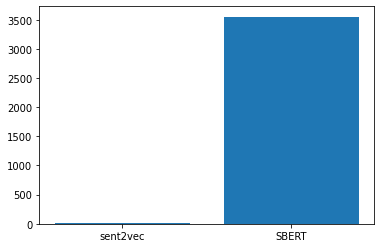

In [0]:
plt.bar(*zip(*processing_time.items()))
print(processing_time)

# SIF embedding / sentence2vec

### code

many versions, not all of them are easy to use:
- https://github.com/oborchers/Fast_Sentence_Embeddings
- https://github.com/peter3125/sentence2vec/blob/master/sentence2vec.py
- https://gist.github.com/bluemonk482/a4b2de9b5037d9ad69fa82da6ae67641
- https://github.com/PrincetonML/SIF/blob/master/src/SIF_embedding.py

We use the library from O Borchers, https://github.com/oborchers/Fast_Sentence_Embeddings

### embedding
We use gensim embeddings:
- https://github.com/RaRe-Technologies/gensim-data

by default, we use glove-wiki-gigaword-100

### warning
make sure that gensim version is gensim==3.8.0 (see top of the notebook)



In [0]:
# install fse library and load the embeddings
# by default, uses glove-wiki-gigaword-100 pretrained embeddings; otherwise, modify the argument path from SIF function
model = compute_embeddings.SIF()
model.load_model()

In [0]:
model.fit(cleaned_questions1+cleaned_questions2)

In [30]:
%%time
start_time = time.time()
embs1 = model.calculate_embeddings(cleaned_questions1)
embs2 = model.calculate_embeddings(cleaned_questions2)

end_time = time.time()
processing_time['SIF'] = np.round(end_time-start_time,2)

CPU times: user 3.88 s, sys: 1.25 s, total: 5.13 s
Wall time: 3.68 s


In [0]:
# np.save('../data/SIF_embeddings1.npy', embs1)
# np.save('../data/SIF_embeddings2.npy', embs2)

# embs1 = np.load('../data/SIF_embeddings1.npy')
# embs2 = np.load('../data/SIF_embeddings2.npy')

In [31]:
features = np.concatenate((embs1, embs2, np.abs(embs2-embs1)), axis=1)
metric_train, metric_valid = modeling.model_efficiency(features, is_duplicates)
# metrics_train['SIF'] = metric_train
# metrics_valid['SIF'] = metric_valid
print(metric_train)
print(metric_valid)

{'loss': 0.6, 'accuracy': 0.69, 'f1': 0.47}
{'loss': 0.59, 'accuracy': 0.69, 'f1': 0.47}


In [70]:
# features = np.concatenate((embs1, embs2, np.abs(embs2-embs1)), axis=1)
model = modeling.get_simple_nn_model(features.shape[1], hidden_sizes=[32, 16, 8])
metric_train, metric_valid = modeling.model_efficiency(features, is_duplicates, model=model, epochs=5, batch_size=64)
# metric_train, metric_valid = model_efficiency(features, is_duplicates, model=model, epochs=5, batch_size=64)
metrics_train_nn['SIF'] = metric_train
metrics_valid_nn['SIF'] = metric_valid
print(metric_train)
print(metric_valid)

Epoch 1/5
4422/4422 [==============================] - 20s 4ms/step - loss: 0.5521 - binary_crossentropy: 0.5521 - accuracy: 0.6585 - val_loss: 0.5469 - val_binary_crossentropy: 0.5469 - val_accuracy: 0.6662
Epoch 2/5
4422/4422 [==============================] - 19s 4ms/step - loss: 0.5458 - binary_crossentropy: 0.5458 - accuracy: 0.6636 - val_loss: 0.5438 - val_binary_crossentropy: 0.5438 - val_accuracy: 0.6652
Epoch 3/5
4422/4422 [==============================] - 20s 4ms/step - loss: 0.5449 - binary_crossentropy: 0.5449 - accuracy: 0.6609 - val_loss: 0.5431 - val_binary_crossentropy: 0.5431 - val_accuracy: 0.6640
Epoch 4/5
4422/4422 [==============================] - 21s 5ms/step - loss: 0.5446 - binary_crossentropy: 0.5446 - accuracy: 0.6607 - val_loss: 0.5431 - val_binary_crossentropy: 0.5431 - val_accuracy: 0.6599
Epoch 5/5
4422/4422 [==============================] - 19s 4ms/step - loss: 0.5445 - binary_crossentropy: 0.5445 - accuracy: 0.6596 - val_loss: 0.5429 - val_binary_cros

{'doc2vec': 682.49, 'sent2vec': 9.01, 'SIF': 18.9, 'SBERT': 3550.54}


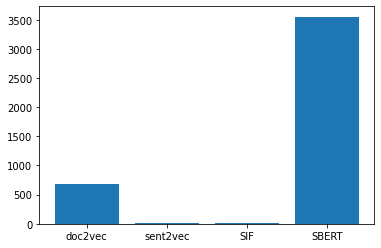

In [0]:
plt.bar(*zip(*processing_time.items()))
print(processing_time)

# Word Count

In [0]:
model = compute_embeddings.Count()
# model = Count()
model.load_model()

In [82]:
# model.fit(questions1 + questions2)
model.fit(list(map(lambda x: ' '.join(x), cleaned_questions1)) + list(map(lambda x: ' '.join(x), cleaned_questions2)))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [83]:
%%time
start_time = time.time()
# count_embs1 = model.calculate_embeddings(questions1)
# count_embs2 = model.calculate_embeddings(questions2)

count_embs1 = model.calculate_embeddings(list(map(lambda x: ' '.join(x), cleaned_questions1)))
count_embs2 = model.calculate_embeddings(list(map(lambda x: ' '.join(x), cleaned_questions2)))

end_time = time.time()
processing_time['Count'] = np.round(end_time-start_time,2)

CPU times: user 7.86 s, sys: 0 ns, total: 7.86 s
Wall time: 7.85 s


In [0]:
# np.save('../data/Count_embeddings1.npy', count_embs1)
# np.save('../data/Count_embeddings2.npy', count_embs2)

In [0]:
import scipy.sparse.linalg
count_features, _, _ = scipy.sparse.linalg.svds(sp.vstack((count_embs1, count_embs2)).astype('float64'),
                                          k=100)
count_features1 = count_features[:len(questions1)]
count_features2 = count_features[-len(questions2):]

In [85]:
features = np.concatenate((count_features1, count_features2, np.abs(count_features2-count_features1)), axis=1)
# metric_train, metric_valid = modeling.model_efficiency(features, is_duplicates)
metric_train, metric_valid = model_efficiency(features, is_duplicates)
metrics_train['Count'] = metric_train
metrics_valid['Count'] = metric_valid
print(metric_train)
print(metric_valid)

{'loss': 0.63, 'accuracy': 0.63, 'f1': 0.01}
{'loss': 0.63, 'accuracy': 0.63, 'f1': 0.01}


In [86]:
# features = np.concatenate((count_features1, count_features2, np.abs(count_features2-count_features1)), axis=1)
model = modeling.get_simple_nn_model(features.shape[1], hidden_sizes=[32, 16, 8])
# metric_train, metric_valid = modeling.model_efficiency(features, is_duplicates, model=model, epochs=5, batch_size=64)
metric_train, metric_valid = model_efficiency(features, is_duplicates, model=model, epochs=5, batch_size=64)
metrics_train_nn['Count'] = metric_train
metrics_valid_nn['Count'] = metric_valid
print(metric_train)
print(metric_valid)

Epoch 1/5
4422/4422 [==============================] - 20s 5ms/step - loss: 0.5847 - binary_crossentropy: 0.5847 - accuracy: 0.6838 - val_loss: 0.5608 - val_binary_crossentropy: 0.5608 - val_accuracy: 0.7029
Epoch 2/5
4422/4422 [==============================] - 20s 4ms/step - loss: 0.5588 - binary_crossentropy: 0.5588 - accuracy: 0.7018 - val_loss: 0.5539 - val_binary_crossentropy: 0.5539 - val_accuracy: 0.7067
Epoch 3/5
4422/4422 [==============================] - 20s 4ms/step - loss: 0.5551 - binary_crossentropy: 0.5551 - accuracy: 0.7036 - val_loss: 0.5504 - val_binary_crossentropy: 0.5504 - val_accuracy: 0.7074
Epoch 4/5
4422/4422 [==============================] - 20s 4ms/step - loss: 0.5511 - binary_crossentropy: 0.5511 - accuracy: 0.7063 - val_loss: 0.5464 - val_binary_crossentropy: 0.5464 - val_accuracy: 0.7107
Epoch 5/5
4422/4422 [==============================] - 22s 5ms/step - loss: 0.5472 - binary_crossentropy: 0.5472 - accuracy: 0.7086 - val_loss: 0.5434 - val_binary_cros

In [0]:
plt.bar(*zip(*processing_time.items()))
print(processing_time)

# TFIDF

In [0]:
model = compute_embeddings.Count()
# model = TFIDF()
model.load_model()

In [88]:
# model.fit(questions1 + questions2)
model.fit(list(map(lambda x: ' '.join(x), cleaned_questions1)) + list(map(lambda x: ' '.join(x), cleaned_questions2)))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [89]:
%%time
start_time = time.time()
# tfidf_embs1 = model.calculate_embeddings(questions1)
# tfidf_embs2 = model.calculate_embeddings(questions2)

tfidf_embs1 = model.calculate_embeddings(list(map(lambda x: ' '.join(x), cleaned_questions1)))
tfidf_embs2 = model.calculate_embeddings(list(map(lambda x: ' '.join(x), cleaned_questions2)))

end_time = time.time()
processing_time['TFIDF'] = np.round(end_time-start_time,2)

CPU times: user 7.87 s, sys: 0 ns, total: 7.87 s
Wall time: 7.87 s


In [0]:
# np.save('../data/TFIDF_embeddings1.npy', tfidf_embs1)
# np.save('../data/TFIDF_embeddings2.npy', tfidf_embs2)

In [0]:
import scipy.sparse.linalg
tfidf_features, _, _ = scipy.sparse.linalg.svds(sp.vstack((tfidf_embs1, tfidf_embs2)).astype('float64'),
                                          k=100)
tfidf_features1 = tfidf_features[:len(questions1)]
tfidf_features2 = tfidf_features[-len(questions2):]

In [91]:
features = np.concatenate((tfidf_features1, tfidf_features2, np.abs(tfidf_features1-tfidf_features2)), axis=1)
# metric_train, metric_valid = modeling.model_efficiency(features, is_duplicates)
metric_train, metric_valid = model_efficiency(features, is_duplicates)
metrics_train['TFIDF'] = metric_train
metrics_valid['TFIDF'] = metric_valid
print(metric_train)
print(metric_valid)

{'loss': 0.63, 'accuracy': 0.63, 'f1': 0.01}
{'loss': 0.63, 'accuracy': 0.63, 'f1': 0.01}


In [92]:
# features = np.concatenate((tfidf_features1, tfidf_features2, np.abs(tfidf_features1-tfidf_features2)), axis=1)
model = modeling.get_simple_nn_model(features.shape[1], hidden_sizes=[32, 16, 8])
# metric_train, metric_valid = modeling.model_efficiency(features, is_duplicates, model=model, epochs=5, batch_size=64)
metric_train, metric_valid = model_efficiency(features, is_duplicates, model=model, epochs=5, batch_size=64)
metrics_train_nn['TFIDF'] = metric_train
metrics_valid_nn['TFIDF'] = metric_valid
print(metric_train)
print(metric_valid)

Epoch 1/5
4422/4422 [==============================] - 20s 5ms/step - loss: 0.5811 - binary_crossentropy: 0.5811 - accuracy: 0.6833 - val_loss: 0.5599 - val_binary_crossentropy: 0.5599 - val_accuracy: 0.7005
Epoch 2/5
4422/4422 [==============================] - 20s 4ms/step - loss: 0.5597 - binary_crossentropy: 0.5597 - accuracy: 0.7002 - val_loss: 0.5571 - val_binary_crossentropy: 0.5571 - val_accuracy: 0.7038
Epoch 3/5
4422/4422 [==============================] - 20s 4ms/step - loss: 0.5562 - binary_crossentropy: 0.5562 - accuracy: 0.7022 - val_loss: 0.5519 - val_binary_crossentropy: 0.5519 - val_accuracy: 0.7061
Epoch 4/5
4422/4422 [==============================] - 20s 4ms/step - loss: 0.5544 - binary_crossentropy: 0.5544 - accuracy: 0.7028 - val_loss: 0.5573 - val_binary_crossentropy: 0.5573 - val_accuracy: 0.7005
Epoch 5/5
4422/4422 [==============================] - 20s 5ms/step - loss: 0.5522 - binary_crossentropy: 0.5522 - accuracy: 0.7045 - val_loss: 0.5482 - val_binary_cros

In [0]:
plt.bar(*zip(*processing_time.items()))
print(processing_time)

# Feature engineering

In [0]:
def jaccard_type_feature(count1, count2, eps=1e-12):
  features = (count1.multiply(count2 != 0) + count2.multiply(count1 != 0)).sum(axis=1)
  features = features / (count1.sum(axis=1) + count2.sum(axis=1) + eps)
  return features

In [94]:
count_features = jaccard_type_feature(count_embs1, count_embs2)
tfidf_features = jaccard_type_feature(tfidf_embs1, tfidf_embs2)

features = np.concatenate((count_features, tfidf_features), axis=1)
features.shape

(404290, 2)

In [95]:
# metric_train, metric_valid = modeling.model_efficiency(features, is_duplicates)
metric_train, metric_valid = model_efficiency(features, is_duplicates)
metrics_train['Count+TFIDF'] = metric_train
metrics_valid['Count+TFIDF'] = metric_valid
print(metric_train)
print(metric_valid)

{'loss': 0.56, 'accuracy': 0.65, 'f1': 0.48}
{'loss': 0.56, 'accuracy': 0.65, 'f1': 0.49}


In [96]:
model = modeling.get_simple_nn_model(features.shape[1], hidden_sizes=[32, 16, 8])
# metric_train, metric_valid = modeling.model_efficiency(features, is_duplicates, model=model, epochs=5, batch_size=64)
metric_train, metric_valid = model_efficiency(features, is_duplicates, model=model, epochs=5, batch_size=64)
metrics_train_nn['Count+TFIDF'] = metric_train
metrics_valid_nn['Count+TFIDF'] = metric_valid
print(metric_train)
print(metric_valid)

Epoch 1/5
4422/4422 [==============================] - 20s 4ms/step - loss: 0.5337 - binary_crossentropy: 0.5337 - accuracy: 0.6663 - val_loss: 0.5279 - val_binary_crossentropy: 0.5279 - val_accuracy: 0.6668
Epoch 2/5
4422/4422 [==============================] - 21s 5ms/step - loss: 0.5263 - binary_crossentropy: 0.5263 - accuracy: 0.6685 - val_loss: 0.5261 - val_binary_crossentropy: 0.5261 - val_accuracy: 0.6697
Epoch 3/5
4422/4422 [==============================] - 20s 5ms/step - loss: 0.5261 - binary_crossentropy: 0.5261 - accuracy: 0.6683 - val_loss: 0.5284 - val_binary_crossentropy: 0.5284 - val_accuracy: 0.6678
Epoch 4/5
4422/4422 [==============================] - 19s 4ms/step - loss: 0.5257 - binary_crossentropy: 0.5257 - accuracy: 0.6682 - val_loss: 0.5244 - val_binary_crossentropy: 0.5244 - val_accuracy: 0.6679
Epoch 5/5
4422/4422 [==============================] - 19s 4ms/step - loss: 0.5253 - binary_crossentropy: 0.5253 - accuracy: 0.6682 - val_loss: 0.5240 - val_binary_cros

# Summary

## Analysis of methods performances

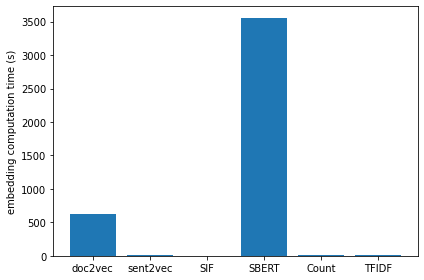

{'doc2vec': 618.72, 'sent2vec': 7.81, 'SIF': 3.68, 'SBERT': 3550.54, 'Count': 6.44, 'TFIDF': 6.21}


In [107]:
plt.bar(*zip(*processing_time.items()))
plt.ylabel('embedding computation time (s)')
plt.tight_layout()
plt.savefig('../images/processing_time.png')
plt.show()
print(processing_time)

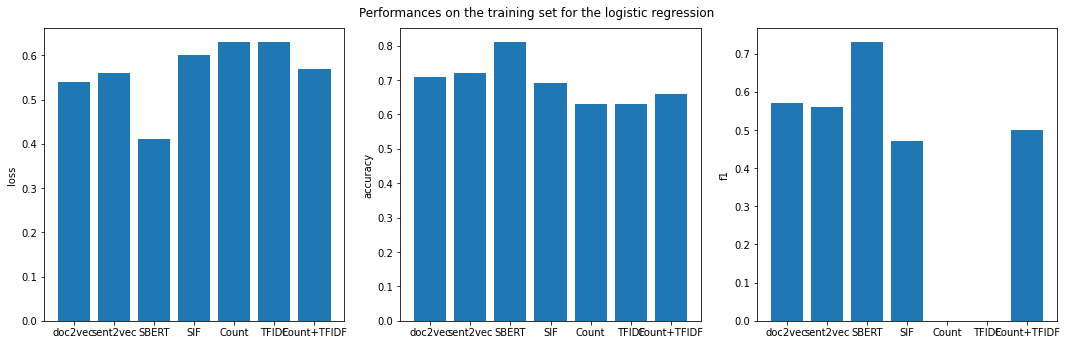

In [115]:
methods = list(metrics_train.keys())
measures = list(metrics_train[methods[0]].keys())
fig, ax = plt.subplots(ncols = len(measures), figsize = (15, 5))
for i, measure in enumerate(measures):
  ax[i].bar(methods, [metrics_train[method][measure] for method in methods])
  ax[i].set_ylabel(measure)

plt.suptitle('Performances on the training set for the logistic regression')
# plt.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../images/performances_logistic_train.png')
plt.show()

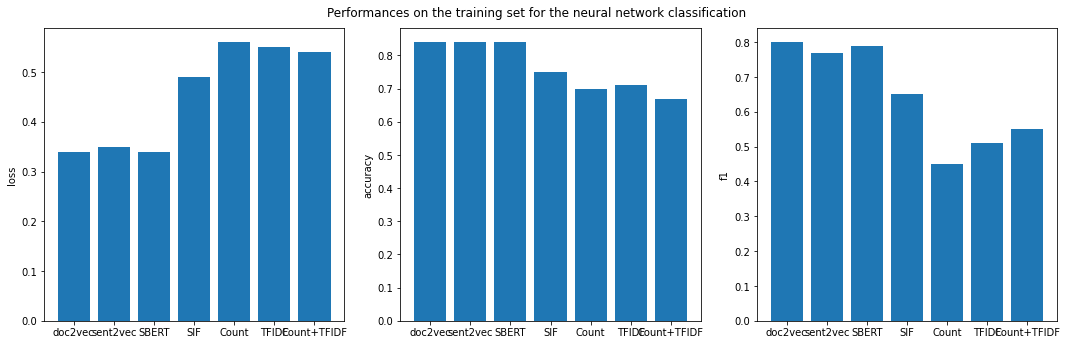

In [120]:
methods = list(metrics_train_nn.keys())
measures = list(metrics_train_nn[methods[0]].keys())
fig, ax = plt.subplots(ncols = len(measures), figsize = (15, 5))
for i, measure in enumerate(measures):
  ax[i].bar(methods, [metrics_train_nn[method][measure] for method in methods])
  ax[i].set_ylabel(measure)

plt.suptitle('Performances on the training set for the neural network classification')
# plt.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../images/performances_neuralnetwork_train.png')
plt.show()

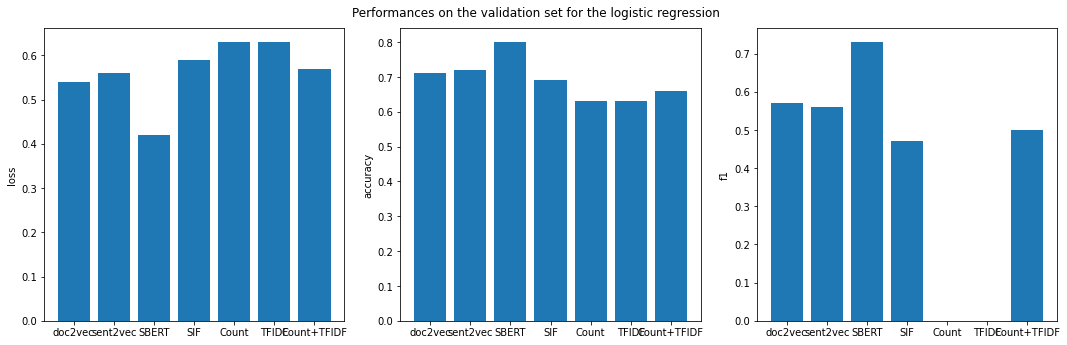

In [119]:
methods = list(metrics_valid.keys())
measures = list(metrics_valid[methods[0]].keys())
fig, ax = plt.subplots(ncols = len(measures), figsize = (15, 5))
for i, measure in enumerate(measures):
  ax[i].bar(methods, [metrics_valid[method][measure] for method in methods])
  ax[i].set_ylabel(measure)

plt.suptitle('Performances on the validation set for the logistic regression')
# plt.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../images/performances_logistic_valid.png')
plt.show()

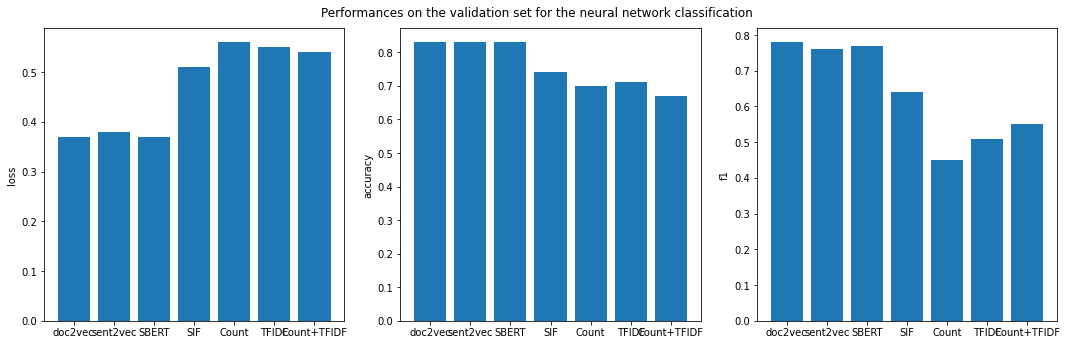

In [122]:
methods = list(metrics_valid_nn.keys())
measures = list(metrics_valid_nn[methods[0]].keys())
fig, ax = plt.subplots(ncols = len(measures), figsize = (15, 5))
for i, measure in enumerate(measures):
  ax[i].bar(methods, [metrics_valid_nn[method][measure] for method in methods])
  ax[i].set_ylabel(measure)

plt.suptitle('Performances on the validation set for the neural network classification')
# plt.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../images/performances_neuralnetwork_valid.png')
plt.show()

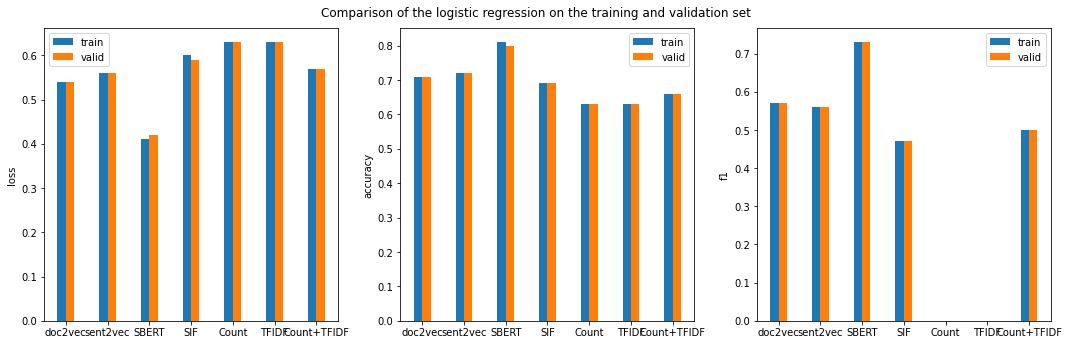

In [124]:
methods = list(metrics_valid.keys())
measures = list(metrics_valid[methods[0]].keys())
fig, ax = plt.subplots(ncols = len(measures), figsize = (15, 5))
for i, measure in enumerate(measures):
  ax[i].bar(np.arange(len(methods))-0.1, [metrics_train[method][measure] for method in methods], width=0.2, label='train')
  ax[i].bar(np.arange(len(methods))+0.1, [metrics_valid[method][measure] for method in methods], width=0.2, label='valid')
  ax[i].set_xticks(np.arange(len(methods)))
  ax[i].set_xticklabels(methods)
  ax[i].set_ylabel(measure)
  ax[i].legend()

plt.suptitle('Comparison of the logistic regression on the training and validation set')
# plt.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../images/performances_logistic_all.png')
plt.show()

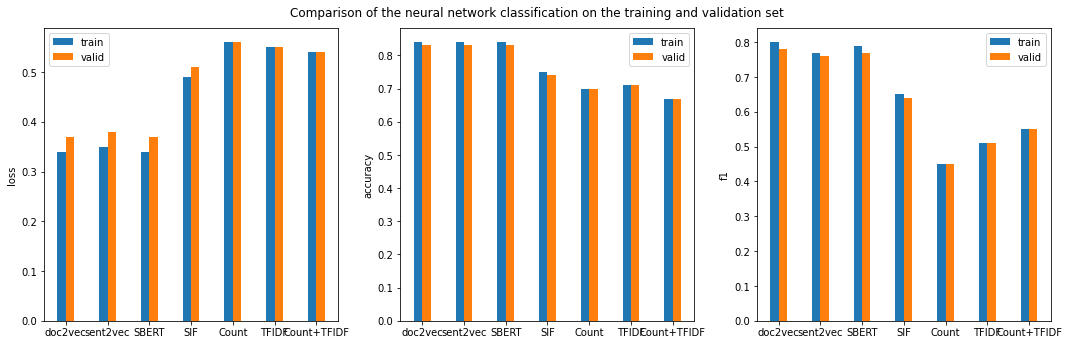

In [126]:
methods = list(metrics_valid_nn.keys())
measures = list(metrics_valid_nn[methods[0]].keys())
fig, ax = plt.subplots(ncols = len(measures), figsize = (15, 5))
for i, measure in enumerate(measures):
  ax[i].bar(np.arange(len(methods))-0.1, [metrics_train_nn[method][measure] for method in methods], width=0.2, label='train')
  ax[i].bar(np.arange(len(methods))+0.1, [metrics_valid_nn[method][measure] for method in methods], width=0.2, label='valid')
  ax[i].set_xticks(np.arange(len(methods)))
  ax[i].set_xticklabels(methods)
  ax[i].set_ylabel(measure)
  ax[i].legend()

plt.suptitle('Comparison of the neural network classification on the training and validation set')
# plt.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../images/performances_neuralnetwork_all.png')
plt.show()

## Comparison of both preprocessing methods

In [0]:
metrics_train_1 = {}
metrics_valid_1 = {}
metrics_train_nn_1 = {}
metrics_valid_nn_1 = {}

metrics_train_2 = {}
metrics_valid_2 = {}
metrics_train_nn_2 = {}
metrics_valid_nn_2 = {}

metrics_train_1['doc2vec'] = {'loss': 0.54, 'accuracy': 0.71, 'f1': 0.57}
metrics_valid_1['doc2vec'] = {'loss': 0.54, 'accuracy': 0.71, 'f1': 0.57}
metrics_train_nn_1['doc2vec'] = {'loss': 0.47, 'accuracy': 0.76, 'f1': 0.68}
metrics_valid_nn_1['doc2vec'] = {'loss': 0.49, 'accuracy': 0.74, 'f1': 0.66}

metrics_train_1['sent2vec'] = {'loss': 0.54, 'accuracy': 0.73, 'f1': 0.58}
metrics_valid_1['sent2vec'] = {'loss': 0.54, 'accuracy': 0.73, 'f1': 0.58}
metrics_train_nn_1['sent2vec'] = {'loss': 0.39, 'accuracy': 0.81, 'f1': 0.74}
metrics_valid_nn_1['sent2vec'] = {'loss': 0.45, 'accuracy': 0.78, 'f1': 0.69}

metrics_train_1['SBERT'] = {'loss': 0.41, 'accuracy': 0.81, 'f1': 0.73}
metrics_valid_1['SBERT'] = {'loss': 0.42, 'accuracy': 0.8, 'f1': 0.73}
metrics_train_nn_1['SBERT'] = {'loss': 0.34, 'accuracy': 0.84, 'f1': 0.79}
metrics_valid_nn_1['SBERT'] = {'loss': 0.37, 'accuracy': 0.83, 'f1': 0.77}

metrics_train_1['SIF'] = {'loss': 0.6, 'accuracy': 0.69, 'f1': 0.47}
metrics_valid_1['SIF'] = {'loss': 0.59, 'accuracy': 0.69, 'f1': 0.47}
metrics_train_nn_1['SIF'] = {'loss': 0.54, 'accuracy': 0.66, 'f1': 0.57}
metrics_valid_nn_1['SIF'] = {'loss': 0.54, 'accuracy': 0.66, 'f1': 0.57}

metrics_train_1['Count'] = {'loss': 0.63, 'accuracy': 0.63, 'f1': 0.01}
metrics_valid_1['Count'] = {'loss': 0.63, 'accuracy': 0.63, 'f1': 0.01}
metrics_train_nn_1['Count'] = {'loss': 0.54, 'accuracy': 0.71, 'f1': 0.51}
metrics_valid_nn_1['Count'] = {'loss': 0.54, 'accuracy': 0.71, 'f1': 0.51}

metrics_train_1['TFIDF'] = {'loss': 0.63, 'accuracy': 0.63, 'f1': 0.01}
metrics_valid_1['TFIDF'] = {'loss': 0.63, 'accuracy': 0.63, 'f1': 0.01}
metrics_train_nn_1['TFIDF'] = {'loss': 0.55, 'accuracy': 0.71, 'f1': 0.5}
metrics_valid_nn_1['TFIDF'] = {'loss': 0.55, 'accuracy': 0.71, 'f1': 0.5}

metrics_train_1['Count+TFIDF'] = {'loss': 0.56, 'accuracy': 0.65, 'f1': 0.48}
metrics_valid_1['Count+TFIDF'] = {'loss': 0.56, 'accuracy': 0.65, 'f1': 0.49}
metrics_train_nn_1['Count+TFIDF'] = {'loss': 0.52, 'accuracy': 0.67, 'f1': 0.61}
metrics_valid_nn_1['Count+TFIDF'] = {'loss': 0.52, 'accuracy': 0.67, 'f1': 0.61}


metrics_train_2['doc2vec'] = {'loss': 0.54, 'accuracy': 0.71, 'f1': 0.57}
metrics_valid_2['doc2vec'] = {'loss': 0.54, 'accuracy': 0.71, 'f1': 0.57}
metrics_train_nn_2['doc2vec'] = {'loss': 0.34, 'accuracy': 0.84, 'f1': 0.8}
metrics_valid_nn_2['doc2vec'] = {'loss': 0.37, 'accuracy': 0.83, 'f1': 0.78}

metrics_train_2['sent2vec'] = {'loss': 0.56, 'accuracy': 0.72, 'f1': 0.56}
metrics_valid_2['sent2vec'] = {'loss': 0.56, 'accuracy': 0.72, 'f1': 0.56}
metrics_train_nn_2['sent2vec'] = {'loss': 0.35, 'accuracy': 0.84, 'f1': 0.77}
metrics_valid_nn_2['sent2vec'] = {'loss': 0.38, 'accuracy': 0.83, 'f1': 0.76}

metrics_train_2['SBERT'] = {'loss': 0.41, 'accuracy': 0.81, 'f1': 0.73}
metrics_valid_2['SBERT'] = {'loss': 0.42, 'accuracy': 0.8, 'f1': 0.73}
metrics_train_nn_2['SBERT'] = {'loss': 0.34, 'accuracy': 0.84, 'f1': 0.79}
metrics_valid_nn_2['SBERT'] = {'loss': 0.37, 'accuracy': 0.83, 'f1': 0.77}

metrics_train_2['SIF'] = {'loss': 0.6, 'accuracy': 0.69, 'f1': 0.47}
metrics_valid_2['SIF'] = {'loss': 0.59, 'accuracy': 0.69, 'f1': 0.47}
metrics_train_nn_2['SIF'] = {'loss': 0.49, 'accuracy': 0.75, 'f1': 0.65}
metrics_valid_nn_2['SIF'] = {'loss': 0.51, 'accuracy': 0.74, 'f1': 0.64}

metrics_train_2['Count'] = {'loss': 0.63, 'accuracy': 0.63, 'f1': 0.0}
metrics_valid_2['Count'] = {'loss': 0.63, 'accuracy': 0.63, 'f1': 0.0}
metrics_train_nn_2['Count'] = {'loss': 0.56, 'accuracy': 0.7, 'f1': 0.45}
metrics_valid_nn_2['Count'] = {'loss': 0.56, 'accuracy': 0.7, 'f1': 0.45}

metrics_train_2['TFIDF'] = {'loss': 0.63, 'accuracy': 0.63, 'f1': 0.0}
metrics_valid_2['TFIDF'] = {'loss': 0.63, 'accuracy': 0.63, 'f1': 0.0}
metrics_train_nn_2['TFIDF'] = {'loss': 0.55, 'accuracy': 0.71, 'f1': 0.51}
metrics_valid_nn_2['TFIDF'] = {'loss': 0.55, 'accuracy': 0.71, 'f1': 0.51}

metrics_train_2['Count+TFIDF'] = {'loss': 0.57, 'accuracy': 0.66, 'f1': 0.5}
metrics_valid_2['Count+TFIDF'] = {'loss': 0.57, 'accuracy': 0.66, 'f1': 0.5}
metrics_train_nn_2['Count+TFIDF'] = {'loss': 0.54, 'accuracy': 0.67, 'f1': 0.55}
metrics_valid_nn_2['Count+TFIDF'] = {'loss': 0.54, 'accuracy': 0.67, 'f1': 0.55}

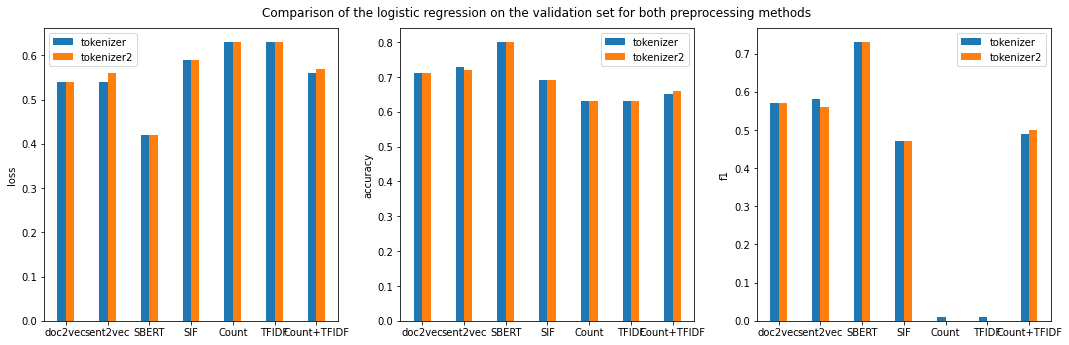

In [128]:
methods = list(metrics_valid_1.keys())
measures = list(metrics_valid_1[methods[0]].keys())
fig, ax = plt.subplots(ncols = len(measures), figsize = (15, 5))
for i, measure in enumerate(measures):
  ax[i].bar(np.arange(len(methods))-0.1, [metrics_valid_1[method][measure] for method in methods], width=0.2, label='tokenizer')
  ax[i].bar(np.arange(len(methods))+0.1, [metrics_valid_2[method][measure] for method in methods], width=0.2, label='tokenizer2')
  ax[i].set_xticks(np.arange(len(methods)))
  ax[i].set_xticklabels(methods)
  ax[i].set_ylabel(measure)
  ax[i].legend()

plt.suptitle('Comparison of the logistic regression on the validation set for both preprocessing methods')
# plt.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../images/comparison_performances_logistic_tokenizers.png')
plt.show()

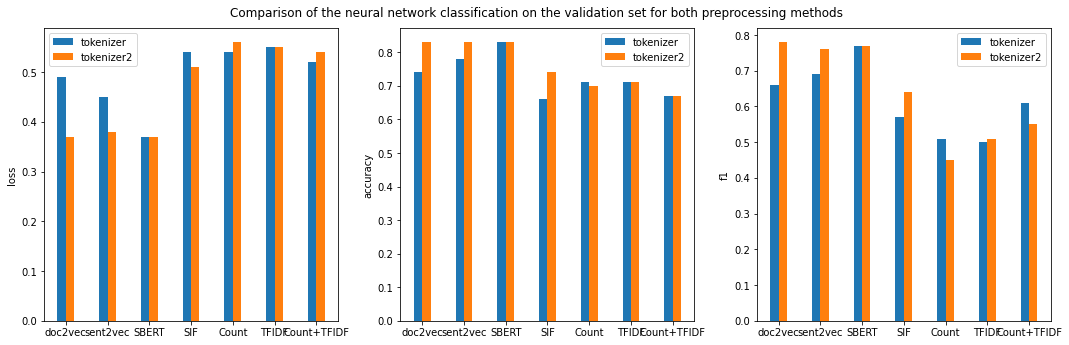

In [130]:
methods = list(metrics_valid_nn_1.keys())
measures = list(metrics_valid_nn_1[methods[0]].keys())
fig, ax = plt.subplots(ncols = len(measures), figsize = (15, 5))
for i, measure in enumerate(measures):
  ax[i].bar(np.arange(len(methods))-0.1, [metrics_valid_nn_1[method][measure] for method in methods], width=0.2, label='tokenizer')
  ax[i].bar(np.arange(len(methods))+0.1, [metrics_valid_nn_2[method][measure] for method in methods], width=0.2, label='tokenizer2')
  ax[i].set_xticks(np.arange(len(methods)))
  ax[i].set_xticklabels(methods)
  ax[i].set_ylabel(measure)
  ax[i].legend()

plt.suptitle('Comparison of the neural network classification on the validation set for both preprocessing methods')
# plt.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../images/comparison_performances_neuralnetwork_tokenizers.png')
plt.show()